In [1]:
from skfeature.function.information_theoretical_based import MRMR

from skfeature.function.information_theoretical_based import MRMR
import mne
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from mat4py import loadmat
import scipy.io
import os
import cv2

In [2]:
# input each epoch and all labels
def extract_data(dset):
    
    epoch1 = pd.read_excel(dset)
    labels_all = pd.read_excel('label_for_ut47_session0.xlsx')

#########################################################################################
#Cal of corr matrix
    epoch1_corrmat=epoch1.corr()
    cordf = pd.DataFrame(epoch1_corrmat)

#########################################################################################
#Cal of Mutual info score
    from sklearn.feature_selection import mutual_info_regression
    #features_X=epoch1
    label_y = []
    for i in range(0,360):
        label_y.append(i)
    y1 = pd.DataFrame(label_y)
    import numpy as np
    X1=np.array(epoch1)
    y2 = np.array(y1.values.ravel())
    mi = mutual_info_regression(X1,y2)
    mi_df = pd.DataFrame(mi,columns=['mutual_info'])
    #print(X1.shape)
    #print(y2.shape)
###########################################################################################
# cal of bandpowers

    import pyeeg

    def BandPower( x ):

        fs = 128
        band = [1,4,8,12,30]

        resp = pyeeg.bin_power(x,band,fs)

        return resp
    import numpy as np
    dfn=epoch1.to_numpy()
    dfn1 = dfn.T

    a=[]
    b=[]
    for i in range(len(dfn1)):
    
        fs = 200
        band = [1,4,8,13,30,100]

        resp = pyeeg.bin_power(dfn1[i],band,fs)
        a.append(resp[0])
        b.append(resp[1])
#pb = pd.DataFrame(a,columns=['Delta','Theta','Alpha','Beta','Gamma'])
    pr = pd.DataFrame(b,columns=['Ratio Delta','Ratio Theta','Ratio Alpha','Ratio Beta','Ratio Gamma'])
#prodata=pd.concat([pb,pr],axis=1)

###########################################################################################
#Cal of stats

    m =pd.DataFrame(epoch1.mean(),columns=['mean'])
    k =pd.DataFrame(epoch1.kurtosis(),columns=['kurtosis'])
    sk= pd.DataFrame(epoch1.skew(),columns=['skew'])
    st=pd.DataFrame(epoch1.std(),columns=['std'])
    all_stats = pd.concat([m,k,sk,st],axis=1)
#stats = pd.DataFrame([m,k,sk,st],columns=['mean','kurtosis','skew','std'])

###########################################################################################
#final test/train dataset

    final_df = pd.concat([cordf,all_stats,pr,mi_df],axis=1)
 # MRMR   
    
    #print(final_df)
    
    
    
    return final_df

In [3]:
train_data = []

DATADIR = 'D:/subjFiles/UT047/behavioral/FR1/epochs eeg for session 0  uta47/data'
CATEGORIES=['Recalled','Not_recalled']

def create_traindata():
    
    for category in CATEGORIES:
        #print(category)
        path = os.path.join(DATADIR, category)
        #print(path)
        class_lab = CATEGORIES.index(category)
        
        
        for ex in os.listdir(path):
            try:
                
                ext_data = extract_data(ex)
                datarry = np.array(ext_data)
                
                
                
                
                train_data.append([datarry,class_lab])
                
            except Exception as e:
                pass
            

            
create_traindata()



In [98]:
label_1 = []
df_1 = []
for data,label in train_data:
    #print(data.size)
    for i in data:
        label_1.append(label)
        df_1.append(i)

    #label.append(j)
    #df_1.append(i)


In [99]:
X = pd.DataFrame(df_1)
y = pd.DataFrame(label_1)

In [100]:
X=X.values
X=X.astype(float)
y1= y.values
y2=y1[:,0]
n_samples, n_features = X.shape 
num_fea = 25
correct = 0
# obtain the index of each feature on the training set
idx,_,_ = MRMR.mrmr(X, y2, n_selected_features=num_fea)
 
    # obtain the dataset on the selected features
features = X[:, idx[0:num_fea]]

In [101]:
pd.DataFrame(features).head()
y2.shape

(19200,)

In [102]:
from sklearn.preprocessing import scale
import  random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
import time
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D,LSTMCell, LSTM,BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
#random.shuffle(train_data)
#feat_all=[]
#label_all=[]
#for features,label in train_data:
#    feat_all.append(features)
#    label_all.append(label)
X1 = np.array(features)
#X1 = tf.keras.utils.normalize(X1)
X1.shape

(19200, 25)

In [125]:
from sklearn.model_selection import train_test_split

#X_train,X_test,y_train,y_test=train_test_split(X1,y2,test_size=0.10,stratify = y2)
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X1,y2,test_size=0.10,stratify=y2,random_state=0)

X_train.shape

(17280, 25)

In [143]:
# Oversampling 

#from imblearn.over_sampling import SMOTE
#sm = SMOTE()
#X_train_1, y_train_2 = sm.fit_sample(X_train, y_train)
X_train_1=tf.keras.utils.normalize(X_train,axis=1)
X_test=tf.keras.utils.normalize(X_test,axis=1)
X_train_1 = X_train_1.reshape(17280,1,25)
X_test = X_test.reshape(1920,1,25)

In [150]:



#BATCH_SIZE = 64

#Name = "MRMR".format(int(time.time()))

model = Sequential()
model.add(LSTM(25,input_shape = X_train_1.shape[1:],activation='relu',return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(25,input_shape = X_train_1.shape[1:],activation='relu',return_sequences=True))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(LSTM(52,input_shape=X_train_1.shape[1:],activation='relu',return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())


model.add(Dense(25,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2,activation='softmax'))
 
#opt = tf.keras.optimizers.Adam(lr=0.001,decay = 1e-6)
model.compile(loss = 'sparse_categorical_crossentropy',optimizer = 'adam', metrics = ['accuracy'])

#tensor_b = TensorBoard(log_dir=f'logs)

model.fit(X_train_1,y_train, epochs =10 ,batch_size = 30,  validation_split=0.10)

Train on 15552 samples, validate on 1728 samples
Epoch 1/10
15552/15552 [==============================] - 7s 432us/sample - loss: 0.7164 - accuracy: 0.5597 - val_loss: 0.6712 - val_accuracy: 0.6244
Epoch 2/10
15552/15552 [==============================] - 4s 230us/sample - loss: 0.6726 - accuracy: 0.6094 - val_loss: 0.6661 - val_accuracy: 0.6244
Epoch 3/10
15552/15552 [==============================] - 4s 257us/sample - loss: 0.6689 - accuracy: 0.6115 - val_loss: 0.6627 - val_accuracy: 0.6244
Epoch 4/10
15552/15552 [==============================] - 4s 267us/sample - loss: 0.6678 - accuracy: 0.6121 - val_loss: 0.6627 - val_accuracy: 0.6244
Epoch 5/10
15552/15552 [==============================] - 4s 277us/sample - loss: 0.6674 - accuracy: 0.6120 - val_loss: 0.6609 - val_accuracy: 0.6244
Epoch 6/10
15552/15552 [==============================] - 4s 265us/sample - loss: 0.6659 - accuracy: 0.6121 - val_loss: 0.6558 - val_accuracy: 0.6244
Epoch 7/10
15552/15552 [===========================

In [138]:
predictions=model.predict(X_test)
predictions_classes=model.predict_classes(X_test)
from sklearn.metrics import confusion_matrix,classification_report
import numpy as np
cm=confusion_matrix(y_test,predictions_classes)
print(classification_report(y_test,predictions_classes))

              precision    recall  f1-score   support

           0       1.00      0.00      0.00       742
           1       0.61      1.00      0.76      1178

    accuracy                           0.61      1920
   macro avg       0.81      0.50      0.38      1920
weighted avg       0.76      0.61      0.47      1920



Confusion matrix, without normalization
[[   0  742]
 [   0 1178]]


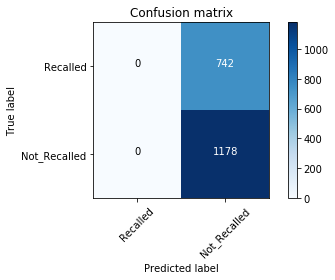

In [136]:
# Confusion Matrix Function for validation dataset

%matplotlib inline
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
cmn=['Recalled','Not_Recalled']
plot_confusion_matrix(cm,cmn,title='Confusion matrix',cmap=plt.cm.Blues)

In [93]:
ypred

array([[[0.40333813, 0.59666187]],

       [[0.40347838, 0.5965216 ]],

       [[0.40339935, 0.59660065]],

       ...,

       [[0.4033496 , 0.5966504 ]],

       [[0.40325785, 0.5967421 ]],

       [[0.4033161 , 0.59668386]]], dtype=float32)

In [94]:
predictions_classes

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]], dtype=int64)

In [130]:
y_test

array([1, 0, 0, ..., 1, 1, 1], dtype=int64)